## **Stock Price Prediction with LSTM and Hyperparameter Optimization Using Optuna**

### **Table of Contents**
1. [Introduction](#Introduction)
2. [Setup and Installation](#Setup-and-Installation)
3. [Project Structure Overview](#Project-Structure-Overview)
4. [Importing Libraries](#Importing-Libraries)
5. [Utility Functions](#Utility-Functions)
6. [Data Preprocessing](#Data-Preprocessing)
7. [Model Definition](#Model-Definition)
8. [Training and Evaluation Functions](#Training-and-Evaluation-Functions)
9. [Hyperparameter Optimization with Optuna](#Hyperparameter-Optimization-with-Optuna)
10. [Training the Final Model](#Training-the-Final-Model)
11. [Model Evaluation and Inference](#Model-Evaluation-and-Inference)
12. [Visualization](#Visualization)
13. [Conclusion](#Conclusion)

---

<a id="Introduction"></a>
## **1. Introduction**

Welcome to the **Stock Price Prediction** tutorial! In this notebook, we will walk through the entire process of building a Long Short-Term Memory (LSTM) neural network to predict stock prices. We'll cover data preprocessing, model training with early stopping, hyperparameter optimization using Optuna, model evaluation, and visualization of results.

By the end of this tutorial, you'll have a solid understanding of how to implement time series forecasting using LSTM networks and optimize your model's performance with advanced hyperparameter tuning techniques.

---

<a id="Setup-and-Installation"></a>
## **2. Setup and Installation**

Before we begin, ensure that you have the necessary libraries installed. You can install them using `pip`. If you're using a virtual environment (which is recommended), activate it first.

```bash
pip install torch numpy pandas scikit-learn matplotlib optuna yfinance
```

**Note:** If you're running this notebook on a system without a GPU, training might be slower. Ensure that PyTorch is installed with the appropriate CUDA version if you intend to use GPU acceleration.

---

<a id="Project-Structure-Overview"></a>
## **3. Project Structure Overview**

For clarity, here's a summary of the project structure we'll be emulating within this notebook:

```
├── data/
│   └── *.parquet                 # Stock data for different symbols
├── src/
│   ├── data_preprocessing.py     # Data preprocessing functions
│   ├── model_training.py         # Model definition and training functions
│   ├── visualization.py          # Plotting functions
│   └── utils.py                  # Utility functions such as directory setup, GPU check
├── main.py                       # Main script to run the entire project
├── README.md                     # Project documentation
└── requirements.txt              # Project dependencies
```

In this notebook, we'll integrate all these components into a single, cohesive workflow with clear explanations and visual aids.

---

<a id="Importing-Libraries"></a>
## **4. Importing Libraries**

Let's start by importing all the necessary libraries. We'll also set up logging to help with debugging and monitoring the progress of our computations.
 
**Explanation:**

- **Logging:** Helps track the flow of the program and debug issues.
- **`functools.partial`:** Allows us to fix certain arguments of a function and generate a new function.
- **`yfinance`:** Used to download stock data.

---

In [21]:
import logging
import os
from functools import partial

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import optuna
import yfinance as yf

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

<a id="Utility-Functions"></a>
## **5. Utility Functions**

Utility functions help keep our code organized and reusable. Below are essential utility functions for setting random seeds, ensuring directory existence, and checking GPU availability.

**Explanation:**

- **`set_seed`:** Ensures that our results are reproducible by setting seeds for various random number generators.
- **`ensure_dir_exists`:** Creates a directory if it doesn't already exist, useful for saving data or models.
- **`check_gpu`:** Determines whether to use a GPU or CPU for computations.
- **`load_data`:** Loads stock data from a specified parquet file, ensuring the file exists.

---

In [22]:
def set_seed(seed=42):
    """
    Sets the seed for reproducibility.
    
    Args:
        seed (int): The seed value to set for random number generators.
    """
    logging.info(f"Setting random seed: {seed}")
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Function to download stock data for a list of symbols
def download_stock_data(symbols, start_date="2015-01-01", end_date=None, data_dir="data"):
    """
    Downloads stock data for the given symbols and saves them as parquet files.

    Args:
        symbols (list): List of stock symbols to download.
        start_date (str): Start date for the data in 'YYYY-MM-DD' format.
        end_date (str): End date for the data in 'YYYY-MM-DD' format. If None, defaults to today's date.
        data_dir (str): Directory to save the downloaded data.

    Returns:
        None
    """
    logging.info("Starting stock data download.")
    ensure_dir_exists(data_dir)
    
    if end_date is None:
        end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
    
    for symbol in symbols:
        logging.info(f"Downloading data for {symbol} from {start_date} to {end_date}.")
        try:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            
            # Flatten MultiIndex if present and clean column names
            if isinstance(stock_data.columns, pd.MultiIndex):
                stock_data.columns = ['_'.join(col).strip().replace(' ', '_') for col in stock_data.columns]

            # Save data to Parquet format for efficient storage
            file_path = os.path.join(data_dir, f"{symbol}_stock_data.parquet")
            stock_data.to_parquet(file_path)
            logging.info(f"Data for {symbol} saved to {file_path}")
        
        except Exception as e:
            logging.error(f"Error downloading data for {symbol}: {e}")

def ensure_dir_exists(dir_path: str):
    """
    Ensures that the specified directory exists; creates it if it does not.
    
    Args:
        dir_path (str): Path to the directory.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        logging.info(f"Directory created: {dir_path}")
    else:
        logging.debug(f"Directory already exists: {dir_path}")

# Check if GPU is available
def check_gpu():
    """
    Checks if a GPU is available and returns the appropriate device.

    Returns:
        device (torch.device): 'cuda' if GPU is available, else 'cpu'.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        logging.info(f"GPU detected: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        logging.info("No GPU detected. Using CPU.")
    
    logging.info(f"CUDA version: {torch.version.cuda}")
    logging.info(f"PyTorch version: {torch.__version__}")
    logging.info(f"Using device: {device}")

    return device

# Load data function
def load_data(filepath):
    """
    Loads stock data from a parquet file.

    Args:
        filepath (str): Path to the parquet file.

    Returns:
        df (pd.DataFrame): DataFrame containing the stock data.
    """
    logging.info(f"Loading data from {filepath}")   
    try:
        df = pd.read_parquet(filepath)
        logging.info(f"Data loaded successfully from {filepath}")
    except FileNotFoundError:
        logging.error(f"File not found: {filepath}")
        raise
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

    return df

<a id="Data-Preprocessing"></a>
## **6. Data Preprocessing**

Data preprocessing is a crucial step in any machine learning pipeline. Here, we'll normalize the stock price data and create input sequences suitable for training our LSTM model.

**Explanation:**

- **`preprocess_data`:** Normalizes the target stock price using `MinMaxScaler` to scale the data between 0 and 1, which is beneficial for training neural networks.
- **`create_sequences`:** Generates input sequences of a specified length (`sequence_length`) and their corresponding future labels (`pred_steps`).
- **`split_data`:** Divides the data into training and validation sets based on the `test_size` ratio.

---

In [23]:
def preprocess_data(df, target_column="Adj_Close", feature_columns=None, scaler=None):
    """
    Preprocesses the data by selecting the target column and normalizing it.

    Args:
        df (pd.DataFrame): DataFrame containing the stock data.
        target_column (str, optional): The name of the target column. Defaults to "Adj_Close".
        feature_columns (_type_, optional): _description_. Defaults to None.
        scaler (_type_, optional): _description_. Defaults to None.

    Returns:
        data_normalized (np.ndarray): Normalized data.
        scaler (MinMaxScaler): Scaler used for normalization.
    """
    logging.info("Starting data preprocessing.")
    if target_column not in df.columns:
        raise KeyError(f"Column '{target_column}' not found in DataFrame.")

    # Select relevant features for LSTM
    feature_columns = feature_columns or [target_column]
    data = df[feature_columns].values

    # Handle missing values (forward and backward fill)
    data = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').values

    # Initialize scaler if none provided
    if scaler is None:
        scaler = MinMaxScaler()

    # Normalize data to the range [0, 1]
    data_normalized = scaler.fit_transform(data)
    
    logging.info(f"Data normalization complete. Shape: {data_normalized.shape}")
    return data_normalized, scaler

def create_sequences(data, sequence_length, pred_steps):
    """
    Creates input sequences and corresponding labels for multi-step prediction.

    Args:
        data (np.ndarray): The normalized data array.
        sequence_length (int): Length of each input sequence.
        pred_steps (int): Number of future steps to predict.

    Returns:
        sequences (np.ndarray): Array of input sequences.
        labels (np.ndarray): Array of corresponding labels (future values).
    """
    logging.info("Creating sequences.")
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length - pred_steps + 1):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length:i + sequence_length + pred_steps]
        sequences.append(seq)
        labels.append(label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    logging.info(f"Sequences created. Number of sequences: {len(sequences)}, Sequence length: {sequence_length}")
    return sequences, labels

def split_data(sequences, labels, test_size=0.2):
    """
    Splits the sequences and labels into training and validation sets.

    Args:
        sequences (np.ndarray): Input sequences.
        labels (np.ndarray): Corresponding labels.
        test_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        X_train (np.ndarray): Training sequences.
        X_val (np.ndarray): Validation sequences.
        y_train (np.ndarray): Training labels.
        y_val (np.ndarray): Validation labels.
    """
    logging.info(f"Splitting data with test size {test_size}.")
    split_index = int(len(sequences) * (1 - test_size))
    X_train = sequences[:split_index]
    y_train = labels[:split_index]
    X_val = sequences[split_index:]
    y_val = labels[split_index:]
    logging.info(f"Data split into {len(X_train)} training and {len(X_val)} validation samples.")
    return X_train, X_val, y_train, y_val


<a id="Model-Definition"></a>
## **7. Model Definition**

Here, we define the LSTM model architecture and implement early stopping to prevent overfitting during training.

**Explanation:**

- **`SequentialLSTM`:** Defines the LSTM architecture tailored for multi-step predictions. The output layer is adjusted to output predictions for multiple future steps.
- **`EarlyStopping`:** Monitors the validation loss and stops training if it doesn't improve after a specified number of epochs (`patience`), helping to prevent overfitting.

---

In [24]:
class SequentialLSTM(nn.Module):
    """
    LSTM model for sequential data.
    
    Args:
        input_size (int): Number of input features.
        hidden_size (int): Number of features in the hidden state.
        num_layers (int): Number of stacked LSTM layers.
        output_size (int): Number of output features.
        pred_steps (int): Number of future steps to predict.
        dropout (float): Dropout rate to prevent overfitting.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, pred_steps, dropout=0.2):
        super(SequentialLSTM, self).__init__()
        self.pred_steps = pred_steps
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size * pred_steps)

    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).
        
        Returns:
            out (torch.Tensor): Output tensor of shape (batch_size, pred_steps, output_size).
        """
        output, (hn, cn) = self.lstm(x)
        out = output[:, -1, :]  # Take the output of the last time step
        out = self.fc(out)      # Linear layer
        out = out.view(-1, self.pred_steps, 1)  # Reshape for multi-step prediction
        return out

class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    
    Args:
        patience (int): Number of epochs to wait before stopping.
        min_delta (float): Minimum change to qualify as an improvement.
    """
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            logging.debug(f"Initial validation loss set to {val_loss:.6f}.")
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            logging.debug(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                logging.info("Early stopping triggered.")
        else:
            self.best_loss = val_loss
            self.counter = 0
            logging.debug(f"Validation loss improved to {val_loss:.6f}.")

<a id="Training-and-Evaluation-Functions"></a>
## **8. Training and Evaluation Functions**

These functions handle the training process, including early stopping, and evaluate the model's performance on the validation set.

**Explanation:**

- **`train_model_with_early_stopping`:** Handles the training loop, including forward and backward passes, loss computation, optimizer steps, validation, and early stopping based on validation loss improvements.
- **`evaluate_model`:** Computes the validation loss, which is crucial for monitoring model performance and for hyperparameter optimization.
- **`save_checkpoint`:** Saves the model's state dictionary, allowing us to reload the best-performing model later.
- **`load_model`:** Loads a saved model's state dictionary and prepares it for inference or further training.

---

In [25]:
def train_model_with_early_stopping(
    model, X_train, y_train, X_val, y_val,
    epochs=500, batch_size=32, learning_rate=0.001, patience=5, verbose=True
):
    """
    Trains the model with early stopping.
    
    Args:
        model (nn.Module): The PyTorch model to train.
        X_train (np.ndarray): Training input data.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation input data.
        y_val (np.ndarray): Validation labels.
        epochs (int): Maximum number of epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
        patience (int): Patience for early stopping.
        verbose (bool): Whether to print training progress.
    
    Returns:
        model (nn.Module): The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logging.info(f"Training on device: {device}")

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=patience)

    # Training loop
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i + batch_size].to(device)
            targets = y_train_tensor[i:i + batch_size].to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor.to(device))
            val_loss = criterion(val_outputs, y_val_tensor.to(device)).item()

        # Calculate average losses
        avg_train_loss = epoch_loss / len(X_train_tensor)

        if verbose:
            logging.info(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, filepath="best_model_temp.pth")

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            if verbose:
                logging.info("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load("best_model_temp.pth"))
    logging.info("Loaded the best model weights.")
    return model

def evaluate_model(model, X_val, y_val):
    """
    Evaluates the model on the validation set.
    
    Args:
        model (nn.Module): The trained PyTorch model.
        X_val (np.ndarray): Validation input data.
        y_val (np.ndarray): Validation labels.
    
    Returns:
        val_loss (float): Validation loss.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        criterion = nn.MSELoss()
        val_loss = criterion(val_outputs, y_val_tensor).item()
    logging.debug(f"Validation loss: {val_loss:.6f}")
    return val_loss

def save_checkpoint(model, filepath="best_model.pth"):
    """
    Saves the model's state dictionary to a file.
    
    Args:
        model (nn.Module): The PyTorch model to save.
        filepath (str): Path to the file where the model will be saved.
    """
    torch.save(model.state_dict(), filepath)
    logging.info(f"Model saved to {filepath}")

def load_model(model: nn.Module, load_path: str, device: torch.device = torch.device("cpu")) -> nn.Module:
    """
    Loads the model state dictionary from a file.
    
    Args:
        model (nn.Module): The model instance to load the state into.
        load_path (str): Path to the saved model file.
        device (torch.device): Device to map the model to.
    
    Returns:
        model (nn.Module): The model with loaded state dictionary.
    """
    model.load_state_dict(torch.load(load_path, map_location=device))
    model.to(device)
    model.eval()
    logging.info(f"Model loaded from {load_path}")
    return model

<a id="Hyperparameter-Optimization-with-Optuna"></a>
## **9. Hyperparameter Optimization with Optuna**

Hyperparameter tuning is essential for maximizing model performance. We'll use Optuna, a powerful hyperparameter optimization framework, to find the best set of hyperparameters for our LSTM model.

**Explanation:**

- **`objective`:** This function defines the hyperparameter space and evaluates the model's performance with different hyperparameter configurations. Optuna will use this function to suggest and evaluate different combinations.
- **Hyperparameters Tuned:**
  - **`hidden_size`:** Number of features in the hidden state of the LSTM.
  - **`num_layers`:** Number of stacked LSTM layers.
  - **`dropout`:** Dropout rate to prevent overfitting.
  - **`learning_rate`:** Learning rate for the optimizer.
  - **`batch_size`:** Number of samples per gradient update.

---

In [26]:
import os
import sys

# Set up the root directory for the project and add it to sys.path
root_dir = os.path.abspath("../")  # Set the project root directory
sys.path.append(root_dir)  # Add the project root to sys.path for imports

# Set up the data directory for the project
data_dir = os.path.join(root_dir, "data")
os.makedirs(data_dir, exist_ok=True)

import logging
import numpy as np
import pandas as pd
import optuna
import torch
from tqdm import tqdm

# Set up logging for detailed tracking of progress
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("project_log.log")  # Log to a file as well
    ]
)

# Set pandas options for better readability
pd.set_option('display.max_columns', None)  # to show all columns
pd.set_option('display.max_rows', None)  # to show all rows

from src.data_preprocessing import create_sequences, preprocess_data, split_data
from src.model_training import SequentialLSTM, train_model_with_early_stopping, evaluate_model, save_checkpoint, load_model
from src.utils import load_data, set_seed, check_gpu, download_stock_data
from src.visualization import plot_predictions, plot_data

# Set random seed for reproducibility
set_seed(42)

# Get device
device = check_gpu()

# Download and dave data
symbols = ["AAPL", "MSFT", "NVDA"]
download_stock_data(symbols, data_dir='../data')
logging.info(f"Downloading data for {symbols}...")

2024-11-28 20:21:26,733 - INFO - Setting random seed: 42
2024-11-28 20:21:26,734 - INFO - GPU detected: NVIDIA GeForce RTX 4090
2024-11-28 20:21:26,735 - INFO - CUDA version: 12.4
2024-11-28 20:21:26,735 - INFO - PyTorch version: 2.5.1+cu124
2024-11-28 20:21:26,736 - INFO - Using device: cuda
2024-11-28 20:21:26,736 - INFO - Starting stock data download.
2024-11-28 20:21:26,736 - INFO - Downloading data for AAPL from 2015-01-01 to 2024-11-28.
[*********************100%***********************]  1 of 1 completed
2024-11-28 20:21:26,781 - INFO - Data for AAPL saved to ../data/AAPL_stock_data.parquet
2024-11-28 20:21:26,781 - INFO - Downloading data for MSFT from 2015-01-01 to 2024-11-28.
[*********************100%***********************]  1 of 1 completed
2024-11-28 20:21:26,814 - INFO - Data for MSFT saved to ../data/MSFT_stock_data.parquet
2024-11-28 20:21:26,814 - INFO - Downloading data for NVDA from 2015-01-01 to 2024-11-28.
[*********************100%***********************]  1 of 1 

<a id="Training-the-Final-Model"></a>
## **10. Training the Final Model**

After finding the best hyperparameters, we'll train the final model using these settings and save it for future use.


**Explanation:**

- **`main_training_loop`:** This function encapsulates the entire training process, from data loading to hyperparameter optimization and final model training.
- **Process Flow:**
  1. **Data Loading and Preprocessing:** Loads the stock data, normalizes it, and creates input sequences.
  2. **Data Splitting:** Divides the data into training and validation sets.
  3. **Hyperparameter Optimization:** Uses Optuna to find the best hyperparameters by minimizing validation loss.
  4. **Final Model Training:** Trains the model using the best hyperparameters found.
  5. **Model Saving:** Saves the trained model for future use.

---

In [27]:
def main_training_loop():
    """
    Executes the main training loop: hyperparameter optimization, training the final model, and saving it.
    
    Returns:
        best_hyperparams (dict): The best hyperparameters found by Optuna.
        best_model (nn.Module): The trained model with the best hyperparameters.
    """
    # Define parameters
    symbol = "AAPL"
    data_file_path = f"data/{symbol}_stock_data.parquet"
    target_column = f"Adj_Close_{symbol}"
    sequence_length = 60  # Number of past days to use for each prediction
    pred_steps = 5        # Number of future days to predict

    # Load the stock data
    df = load_data(data_file_path)

    # Preprocess the data
    data_normalized, scaler = preprocess_data(df, target_column)

    # Create sequences and labels
    sequences, labels = create_sequences(data_normalized, sequence_length, pred_steps)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = split_data(sequences, labels, test_size=0.2)

    # Define the objective function with additional arguments using partial
    study_objective = partial(objective, pred_steps=pred_steps, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

    # Create the Optuna study
    study = optuna.create_study(direction='minimize', study_name='LSTM_Hyperparameter_Optimization')

    # Run the hyperparameter optimization
    logging.info("Starting hyperparameter optimization with Optuna.")
    study.optimize(study_objective, n_trials=20, timeout=None)  # Adjust n_trials as needed

    # Retrieve the best hyperparameters
    best_hyperparams = study.best_params
    logging.info("Best hyperparameters found:")
    for key, value in best_hyperparams.items():
        logging.info(f"{key}: {value}")

    # Instantiate the best model
    best_model = SequentialLSTM(
        input_size=1,
        hidden_size=best_hyperparams['hidden_size'],
        num_layers=best_hyperparams['num_layers'],
        output_size=1,
        pred_steps=pred_steps,
        dropout=best_hyperparams['dropout']
    )

    # Train the best model with the best hyperparameters
    logging.info("Training the best model with the best hyperparameters.")
    best_model = train_model_with_early_stopping(
        best_model, X_train, y_train, X_val, y_val,
        epochs=100,
        batch_size=best_hyperparams['batch_size'],
        learning_rate=best_hyperparams['learning_rate'],
        patience=5,
        verbose=True
    )

    # Save the best model
    save_checkpoint(best_model, filepath="best_model.pth")

    return best_hyperparams, best_model, scaler, sequence_length

<a id="Model-Evaluation-and-Inference"></a>
## **11. Model Evaluation and Inference**

With the trained model, we can now evaluate its performance on the validation set and make future predictions.


**Explanation:**

- **`perform_inference`:** Uses the trained model to predict future stock prices based on the latest available data. It processes the last input sequence, makes predictions, inversely transforms the normalized predictions to their original scale, and logs the results.

---

In [28]:
def perform_inference(model, scaler, sequence_length, pred_steps, data_normalized):
    """
    Performs inference to predict future stock prices.
    
    Args:
        model (nn.Module): The trained PyTorch model.
        scaler (MinMaxScaler): Scaler used for data normalization.
        sequence_length (int): Length of input sequences.
        pred_steps (int): Number of future steps to predict.
        data_normalized (np.ndarray): Normalized stock price data.
    
    Returns:
        future_prices (np.ndarray): Predicted future stock prices.
    """
    device = check_gpu()
    model.to(device)
    model.eval()

    # Prepare the last sequence from the data for inference
    last_sequence = data_normalized[-sequence_length:]
    last_sequence = last_sequence.reshape(1, sequence_length, 1)  # Shape: (1, sequence_length, input_size)
    last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).to(device)

    # Predict future prices
    logging.info(f"Predicting the next {pred_steps} days of stock prices.")
    with torch.no_grad():
        future_predictions = model(last_sequence_tensor)  # Shape: (1, pred_steps, output_size)
        future_predictions = future_predictions.cpu().numpy().reshape(-1, 1)

    # Inverse transform to get actual prices
    future_prices = scaler.inverse_transform(future_predictions).flatten()

    # Print predicted future prices
    logging.info(f"Predicted prices for the next {pred_steps} days:")
    for i, price in enumerate(future_prices, 1):
        logging.info(f"Day {i}: ${price:.2f}")

    return future_prices

<a id="Visualization"></a>
## **12. Visualization**

Visualizing data and model predictions is vital for understanding performance and trends. Here, we'll plot the actual vs. predicted prices and visualize the stock price trends.


**Explanation:**

- **`plot_final_predictions`:** Combines the last 60 days of actual stock prices with the predicted future prices and plots them for visual comparison. This helps in assessing how well the model is predicting future trends based on recent data.

---

In [29]:
def plot_final_predictions(last_60_days, future_prices, symbol, sequence_length, pred_steps):
    """
    Plots the last 60 days of actual stock prices and the predicted next days.
    
    Args:
        last_60_days (np.ndarray): Array of the last 60 days of actual prices.
        future_prices (np.ndarray): Array of predicted future prices.
        symbol (str): Stock symbol.
        sequence_length (int): Number of past days used for prediction.
        pred_steps (int): Number of future days predicted.
    
    Returns:
        None
    """
    logging.info("Plotting the final predictions.")
    plot_prices = np.concatenate((last_60_days, future_prices))

    plt.figure(figsize=(12, 6))
    plt.plot(range(sequence_length), last_60_days, label='Last 60 Days')
    plt.plot(range(sequence_length, sequence_length + pred_steps), future_prices, label='Predicted Next Days', linestyle='--', marker='o')
    plt.title(f"{symbol} Last {sequence_length} Days and Predicted Next {pred_steps} Days")
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

<a id="Conclusion"></a>
## **13. Conclusion**

Congratulations! You've successfully built and trained an LSTM model for stock price prediction, optimized its hyperparameters using Optuna, and visualized the results. Here's a recap of what we've accomplished:

1. **Data Preprocessing:** Loaded, normalized, and created sequences from stock price data.
2. **Model Definition:** Defined an LSTM architecture suitable for multi-step predictions.
3. **Training with Early Stopping:** Implemented training loops that halt when the model stops improving, preventing overfitting.
4. **Hyperparameter Optimization:** Leveraged Optuna to find the best set of hyperparameters, enhancing model performance.
5. **Evaluation and Inference:** Assessed the model's performance on validation data and made future price predictions.
6. **Visualization:** Plotted actual vs. predicted prices to intuitively understand model accuracy.

**Next Steps:**

- **Expand the Dataset:** Incorporate more features (e.g., volume, technical indicators) to potentially improve prediction accuracy.
- **Experiment with Different Models:** Explore other architectures like GRUs or Transformer-based models.
- **Deploy the Model:** Integrate the trained model into a production environment for real-time predictions.
- **Continuous Learning:** Implement mechanisms to update the model with new data over time.

Feel free to experiment further and adapt the pipeline to suit your specific requirements. Happy forecasting!

---

### **Appendix: Complete Code Snippets**

For convenience, below are the complete code snippets for each section. You can copy and paste them into separate cells in your Jupyter Notebook.

---

#### **Utility Functions**

In [30]:
def set_seed(seed=42):
    """
    Sets the seed for reproducibility.
    
    Args:
        seed (int): The seed value to set for random number generators.
    """
    logging.info(f"Setting random seed: {seed}")
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Function to download stock data for a list of symbols
def download_stock_data(symbols, start_date="2015-01-01", end_date=None, data_dir="data"):
    """
    Downloads stock data for the given symbols and saves them as parquet files.

    Args:
        symbols (list): List of stock symbols to download.
        start_date (str): Start date for the data in 'YYYY-MM-DD' format.
        end_date (str): End date for the data in 'YYYY-MM-DD' format. If None, defaults to today's date.
        data_dir (str): Directory to save the downloaded data.

    Returns:
        None
    """
    logging.info("Starting stock data download.")
    ensure_dir_exists(data_dir)
    
    if end_date is None:
        end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
    
    for symbol in symbols:
        logging.info(f"Downloading data for {symbol} from {start_date} to {end_date}.")
        try:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            
            # Flatten MultiIndex if present and clean column names
            if isinstance(stock_data.columns, pd.MultiIndex):
                stock_data.columns = ['_'.join(col).strip().replace(' ', '_') for col in stock_data.columns]

            # Save data to Parquet format for efficient storage
            file_path = os.path.join(data_dir, f"{symbol}_stock_data.parquet")
            stock_data.to_parquet(file_path)
            logging.info(f"Data for {symbol} saved to {file_path}")
        
        except Exception as e:
            logging.error(f"Error downloading data for {symbol}: {e}")

def ensure_dir_exists(dir_path: str):
    """
    Ensures that the specified directory exists; creates it if it does not.
    
    Args:
        dir_path (str): Path to the directory.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        logging.info(f"Directory created: {dir_path}")
    else:
        logging.debug(f"Directory already exists: {dir_path}")

# Check if GPU is available
def check_gpu():
    """
    Checks if a GPU is available and returns the appropriate device.

    Returns:
        device (torch.device): 'cuda' if GPU is available, else 'cpu'.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        logging.info(f"GPU detected: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        logging.info("No GPU detected. Using CPU.")
    
    logging.info(f"CUDA version: {torch.version.cuda}")
    logging.info(f"PyTorch version: {torch.__version__}")
    logging.info(f"Using device: {device}")

    return device

# Load data function
def load_data(filepath):
    """
    Loads stock data from a parquet file.

    Args:
        filepath (str): Path to the parquet file.

    Returns:
        df (pd.DataFrame): DataFrame containing the stock data.
    """
    logging.info(f"Loading data from {filepath}")   
    try:
        df = pd.read_parquet(filepath)
        logging.info(f"Data loaded successfully from {filepath}")
    except FileNotFoundError:
        logging.error(f"File not found: {filepath}")
        raise
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

    return df

#### **Data Preprocessing**

In [31]:
def preprocess_data(df, target_column="Adj_Close", feature_columns=None, scaler=None):
    """
    Preprocesses the data by selecting the target column and normalizing it.

    Args:
        df (pd.DataFrame): DataFrame containing the stock data.
        target_column (str, optional): The name of the target column. Defaults to "Adj_Close".
        feature_columns (_type_, optional): _description_. Defaults to None.
        scaler (_type_, optional): _description_. Defaults to None.

    Returns:
        data_normalized (np.ndarray): Normalized data.
        scaler (MinMaxScaler): Scaler used for normalization.
    """
    logging.info("Starting data preprocessing.")
    if target_column not in df.columns:
        raise KeyError(f"Column '{target_column}' not found in DataFrame.")

    # Select relevant features for LSTM
    feature_columns = feature_columns or [target_column]
    data = df[feature_columns].values

    # Handle missing values (forward and backward fill)
    data = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').values

    # Initialize scaler if none provided
    if scaler is None:
        scaler = MinMaxScaler()

    # Normalize data to the range [0, 1]
    data_normalized = scaler.fit_transform(data)
    
    logging.info(f"Data normalization complete. Shape: {data_normalized.shape}")
    return data_normalized, scaler

def create_sequences(data, sequence_length, pred_steps):
    """
    Creates input sequences and corresponding labels for multi-step prediction.

    Args:
        data (np.ndarray): The normalized data array.
        sequence_length (int): Length of each input sequence.
        pred_steps (int): Number of future steps to predict.

    Returns:
        sequences (np.ndarray): Array of input sequences.
        labels (np.ndarray): Array of corresponding labels (future values).
    """
    logging.info("Creating sequences.")
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length - pred_steps + 1):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length:i + sequence_length + pred_steps]
        sequences.append(seq)
        labels.append(label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    logging.info(f"Sequences created. Number of sequences: {len(sequences)}, Sequence length: {sequence_length}")
    return sequences, labels

def split_data(sequences, labels, test_size=0.2):
    """
    Splits the sequences and labels into training and validation sets.

    Args:
        sequences (np.ndarray): Input sequences.
        labels (np.ndarray): Corresponding labels.
        test_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        X_train (np.ndarray): Training sequences.
        X_val (np.ndarray): Validation sequences.
        y_train (np.ndarray): Training labels.
        y_val (np.ndarray): Validation labels.
    """
    logging.info(f"Splitting data with test size {test_size}.")
    split_index = int(len(sequences) * (1 - test_size))
    X_train = sequences[:split_index]
    y_train = labels[:split_index]
    X_val = sequences[split_index:]
    y_val = labels[split_index:]
    logging.info(f"Data split into {len(X_train)} training and {len(X_val)} validation samples.")
    return X_train, X_val, y_train, y_val


#### **Model Definition**

In [32]:
class SequentialLSTM(nn.Module):
    """
    LSTM model for sequential data.
    
    Args:
        input_size (int): Number of input features.
        hidden_size (int): Number of features in the hidden state.
        num_layers (int): Number of stacked LSTM layers.
        output_size (int): Number of output features.
        pred_steps (int): Number of future steps to predict.
        dropout (float): Dropout rate to prevent overfitting.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, pred_steps, dropout=0.2):
        super(SequentialLSTM, self).__init__()
        self.pred_steps = pred_steps
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size * pred_steps)

    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).
        
        Returns:
            out (torch.Tensor): Output tensor of shape (batch_size, pred_steps, output_size).
        """
        output, (hn, cn) = self.lstm(x)
        out = output[:, -1, :]  # Take the output of the last time step
        out = self.fc(out)      # Linear layer
        out = out.view(-1, self.pred_steps, 1)  # Reshape for multi-step prediction
        return out

class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    
    Args:
        patience (int): Number of epochs to wait before stopping.
        min_delta (float): Minimum change to qualify as an improvement.
    """
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            logging.debug(f"Initial validation loss set to {val_loss:.6f}.")
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            logging.debug(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                logging.info("Early stopping triggered.")
        else:
            self.best_loss = val_loss
            self.counter = 0
            logging.debug(f"Validation loss improved to {val_loss:.6f}.")

#### **Training and Evaluation Functions**

In [33]:
def train_model_with_early_stopping(
    model, X_train, y_train, X_val, y_val,
    epochs=500, batch_size=32, learning_rate=0.001, patience=5, verbose=True
):
    """
    Trains the model with early stopping.
    
    Args:
        model (nn.Module): The PyTorch model to train.
        X_train (np.ndarray): Training input data.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation input data.
        y_val (np.ndarray): Validation labels.
        epochs (int): Maximum number of epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
        patience (int): Patience for early stopping.
        verbose (bool): Whether to print training progress.
    
    Returns:
        model (nn.Module): The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logging.info(f"Training on device: {device}")

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=patience)

    # Training loop
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i + batch_size].to(device)
            targets = y_train_tensor[i:i + batch_size].to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor.to(device))
            val_loss = criterion(val_outputs, y_val_tensor.to(device)).item()

        # Calculate average losses
        avg_train_loss = epoch_loss / len(X_train_tensor)

        if verbose:
            logging.info(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, filepath="best_model_temp.pth")

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            if verbose:
                logging.info("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load("best_model_temp.pth"))
    logging.info("Loaded the best model weights.")
    return model

def evaluate_model(model, X_val, y_val):
    """
    Evaluates the model on the validation set.
    
    Args:
        model (nn.Module): The trained PyTorch model.
        X_val (np.ndarray): Validation input data.
        y_val (np.ndarray): Validation labels.
    
    Returns:
        val_loss (float): Validation loss.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        criterion = nn.MSELoss()
        val_loss = criterion(val_outputs, y_val_tensor).item()
    logging.debug(f"Validation loss: {val_loss:.6f}")
    return val_loss

def save_checkpoint(model, filepath="best_model.pth"):
    """
    Saves the model's state dictionary to a file.
    
    Args:
        model (nn.Module): The PyTorch model to save.
        filepath (str): Path to the file where the model will be saved.
    """
    torch.save(model.state_dict(), filepath)
    logging.info(f"Model saved to {filepath}")

def load_model(model: nn.Module, load_path: str, device: torch.device = torch.device("cpu")) -> nn.Module:
    """
    Loads the model state dictionary from a file.
    
    Args:
        model (nn.Module): The model instance to load the state into.
        load_path (str): Path to the saved model file.
        device (torch.device): Device to map the model to.
    
    Returns:
        model (nn.Module): The model with loaded state dictionary.
    """
    model.load_state_dict(torch.load(load_path, map_location=device))
    model.to(device)
    model.eval()
    logging.info(f"Model loaded from {load_path}")
    return model

#### **Hyperparameter Optimization with Optuna**

In [34]:
def objective(trial, pred_steps, X_train, y_train, X_val, y_val):
    """
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        pred_steps (int): Number of future steps to predict.
        X_train (np.ndarray): Training input data.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation input data.
        y_val (np.ndarray): Validation labels.
    
    Returns:
        val_loss (float): Validation loss after training.
    """
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_uniform('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    logging.info(f"Trial {trial.number}: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, learning_rate={learning_rate}, batch_size={batch_size}")

    # Instantiate the model
    model = SequentialLSTM(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1,
        pred_steps=pred_steps,
        dropout=dropout
    )

    # Train the model
    model = train_model_with_early_stopping(
        model, X_train, y_train, X_val, y_val,
        epochs=100,
        batch_size=batch_size,
        learning_rate=learning_rate,
        patience=5,
        verbose=False  # Suppress output during optimization
    )

    # Evaluate the model
    val_loss = evaluate_model(model, X_val, y_val)

    logging.info(f"Trial {trial.number}: Validation Loss={val_loss:.6f}")

    return val_loss

#### **Final Model Training and Inference**

In [35]:
def perform_inference(model, scaler, sequence_length, pred_steps, data_normalized):
    """
    Performs inference to predict future stock prices.
    
    Args:
        model (nn.Module): The trained PyTorch model.
        scaler (MinMaxScaler): Scaler used for data normalization.
        sequence_length (int): Length of input sequences.
        pred_steps (int): Number of future steps to predict.
        data_normalized (np.ndarray): Normalized stock price data.
    
    Returns:
        future_prices (np.ndarray): Predicted future stock prices.
    """
    device = check_gpu()
    model.to(device)
    model.eval()

    # Prepare the last sequence from the data for inference
    last_sequence = data_normalized[-sequence_length:]
    last_sequence = last_sequence.reshape(1, sequence_length, 1)  # Shape: (1, sequence_length, input_size)
    last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).to(device)

    # Predict future prices
    logging.info(f"Predicting the next {pred_steps} days of stock prices.")
    with torch.no_grad():
        future_predictions = model(last_sequence_tensor)  # Shape: (1, pred_steps, output_size)
        future_predictions = future_predictions.cpu().numpy().reshape(-1, 1)

    # Inverse transform to get actual prices
    future_prices = scaler.inverse_transform(future_predictions).flatten()

    # Print predicted future prices
    logging.info(f"Predicted prices for the next {pred_steps} days:")
    for i, price in enumerate(future_prices, 1):
        logging.info(f"Day {i}: ${price:.2f}")

    return future_prices

#### **Visualization**

In [36]:
def plot_final_predictions(last_60_days, future_prices, symbol, sequence_length, pred_steps):
    """
    Plots the last 60 days of actual stock prices and the predicted next days.
    
    Args:
        last_60_days (np.ndarray): Array of the last 60 days of actual prices.
        future_prices (np.ndarray): Array of predicted future prices.
        symbol (str): Stock symbol.
        sequence_length (int): Number of past days used for prediction.
        pred_steps (int): Number of future days predicted.
    
    Returns:
        None
    """
    logging.info("Plotting the final predictions.")
    plot_prices = np.concatenate((last_60_days, future_prices))

    plt.figure(figsize=(12, 6))
    plt.plot(range(sequence_length), last_60_days, label='Last 60 Days')
    plt.plot(range(sequence_length, sequence_length + pred_steps), future_prices, label='Predicted Next Days', linestyle='--', marker='o')
    plt.title(f"{symbol} Last {sequence_length} Days and Predicted Next {pred_steps} Days")
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

#### **Complete Training Loop**

In [37]:
def main_training_loop():
    """
    Executes the main training loop: hyperparameter optimization, training the final model, and saving it.
    
    Returns:
        best_hyperparams (dict): The best hyperparameters found by Optuna.
        best_model (nn.Module): The trained model with the best hyperparameters.
    """
    # Define parameters
    symbol = "AAPL"
    data_file_path = f"../data/{symbol}_stock_data.parquet"
    target_column = f"Adj_Close_{symbol}"
    sequence_length = 60  # Number of past days to use for each prediction
    pred_steps = 5        # Number of future days to predict

    # Load the stock data
    df = load_data(data_file_path)
    
    # Preprocess the data
    data_normalized, scaler = preprocess_data(df, target_column)

    # Create sequences and labels
    sequences, labels = create_sequences(data_normalized, sequence_length, pred_steps)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = split_data(sequences, labels, test_size=0.2)

    # Define the objective function with additional arguments using partial
    study_objective = partial(objective, pred_steps=pred_steps, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

    # Create the Optuna study
    study = optuna.create_study(direction='minimize', study_name='LSTM_Hyperparameter_Optimization')

    # Run the hyperparameter optimization
    logging.info("Starting hyperparameter optimization with Optuna.")
    study.optimize(study_objective, n_trials=20, timeout=None)  # Adjust n_trials as needed

    # Retrieve the best hyperparameters
    best_hyperparams = study.best_params
    logging.info("Best hyperparameters found:")
    for key, value in best_hyperparams.items():
        logging.info(f"{key}: {value}")

    # Instantiate the best model
    best_model = SequentialLSTM(
        input_size=1,
        hidden_size=best_hyperparams['hidden_size'],
        num_layers=best_hyperparams['num_layers'],
        output_size=1,
        pred_steps=pred_steps,
        dropout=best_hyperparams['dropout']
    )

    # Train the best model with the best hyperparameters
    logging.info("Training the best model with the best hyperparameters.")
    best_model = train_model_with_early_stopping(
        best_model, X_train, y_train, X_val, y_val,
        epochs=100,
        batch_size=best_hyperparams['batch_size'],
        learning_rate=best_hyperparams['learning_rate'],
        patience=5,
        verbose=True
    )

    # Save the best model
    save_checkpoint(best_model, filepath="best_model.pth")

    return best_hyperparams, best_model, scaler, sequence_length, pred_steps, data_normalized

#### **Running the Training Loop and Performing Inference**

In [38]:
# Execute the main training loop
best_hyperparams, best_model, scaler, sequence_length, pred_steps, data_normalized = main_training_loop()

# Perform inference to predict future stock prices
future_prices = perform_inference(best_model, scaler, sequence_length, pred_steps, data_normalized)

2024-11-28 20:21:27,048 - INFO - Loading data from ../data/AAPL_stock_data.parquet
2024-11-28 20:21:27,052 - INFO - Data loaded successfully from ../data/AAPL_stock_data.parquet
2024-11-28 20:21:27,052 - INFO - Starting data preprocessing.
/tmp/ipykernel_1230896/3010830827.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').values
2024-11-28 20:21:27,054 - INFO - Data normalization complete. Shape: (2494, 1)
2024-11-28 20:21:27,055 - INFO - Creating sequences.
2024-11-28 20:21:27,058 - INFO - Sequences created. Number of sequences: 2430, Sequence length: 60
2024-11-28 20:21:27,058 - INFO - Splitting data with test size 0.2.
2024-11-28 20:21:27,059 - INFO - Data split into 1944 training and 486 validation samples.
[I 2024-11-28 20:21:27,060] A new study created in memory with name: LSTM_Hyperparameter_Optimization
2024-11-28

#### **Visualization of Predictions**

2024-11-28 20:22:14,974 - INFO - Plotting the final predictions.


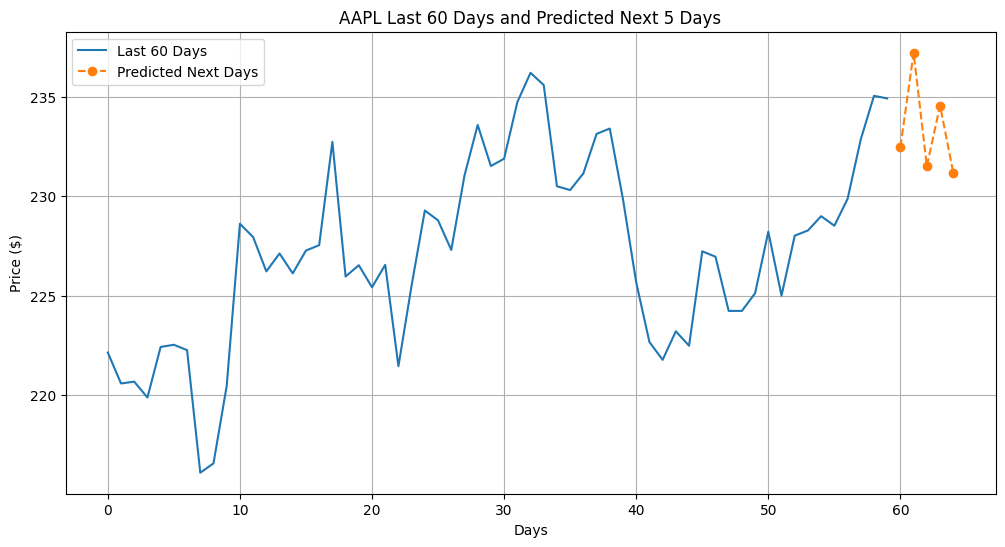

In [39]:
# Prepare data for plotting
last_60_days_prices = scaler.inverse_transform(data_normalized[-sequence_length:].reshape(-1, 1)).flatten()

# Plot the last 60 days and the predicted next days
plot_final_predictions(
    last_60_days=last_60_days_prices,
    future_prices=future_prices,
    symbol="AAPL",
    sequence_length=sequence_length,
    pred_steps=pred_steps
)